In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from environment import TrafficModel, Car
from util.network import create_braess_network, create_double_braess_network, create_cars

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import trange

## Find optimal capacity for unrestricted vs. restricted

100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


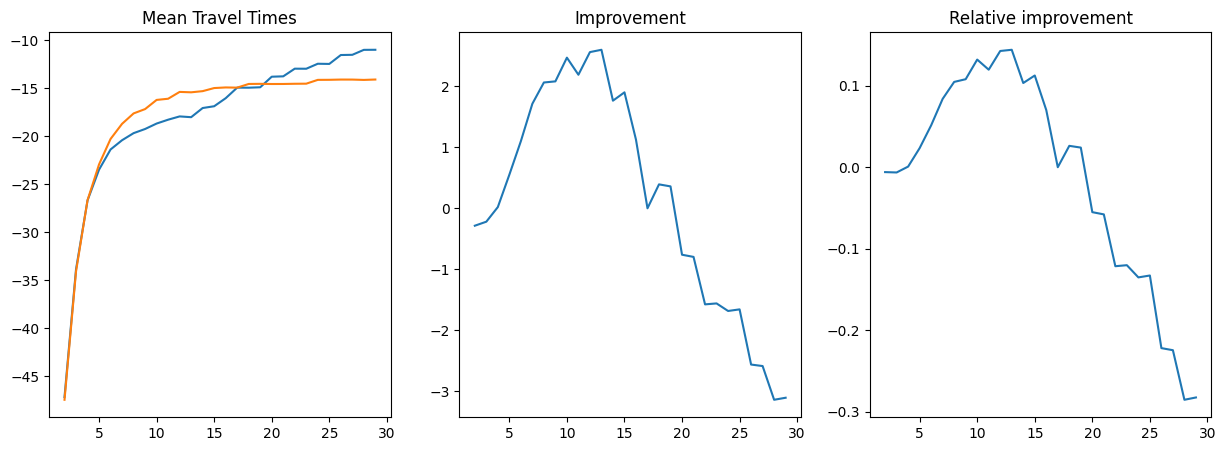

Best improvement found with capacity: 13


In [3]:
number_of_steps = 1000
car_counts = {(0, 3): 30}

mean_travel_times_allowed = []
mean_travel_times_prohibited = []
for capacity in trange(2, 30):
    for allowed_edge in [True, False]:
        network = create_braess_network(capacity=capacity)
        model = TrafficModel(network, create_cars(network, car_counts=car_counts))
        model.set_edge_restriction((1, 2), allowed=allowed_edge)
        step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

        if allowed_edge:
            mean_travel_times_allowed.append((-car_stats["travel_time"]).mean())
        else:
            mean_travel_times_prohibited.append((-car_stats["travel_time"]).mean())

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(range(2,30), pd.DataFrame({'allowed': mean_travel_times_allowed, 'prohibited': mean_travel_times_prohibited}))
ax1.set_title('Mean Travel Times')

improvement = np.array(mean_travel_times_prohibited) - np.array(mean_travel_times_allowed)
ax2.plot(range(2,30), improvement)
ax2.set_title('Improvement')

relative_improvement = improvement / abs(np.array(mean_travel_times_allowed))
ax3.plot(range(2,30), relative_improvement)
ax3.set_title('Relative improvement')

plt.show()

print(f'Best improvement found with capacity: {np.argmax(improvement) + 2}')

## Test scenarios individually

In [102]:
def plot_results(car_stats, *, title):
    stats = car_stats.set_index('step')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    pd.DataFrame({route: stats['route'] == route for route in stats['route'].unique()}).expanding().mean().plot(ax=ax1)
    ax1.legend(stats['route'].unique())
    ax1.set_title('Fraction of cars per route')

    pd.DataFrame({'Travel time': stats['travel_time'], 'Total cost': stats['total_cost']}).expanding().mean().plot(ax=ax2)
    ax2.set_title('Social welfare')

    fig.suptitle(title)

### Unrestricted

In [103]:
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

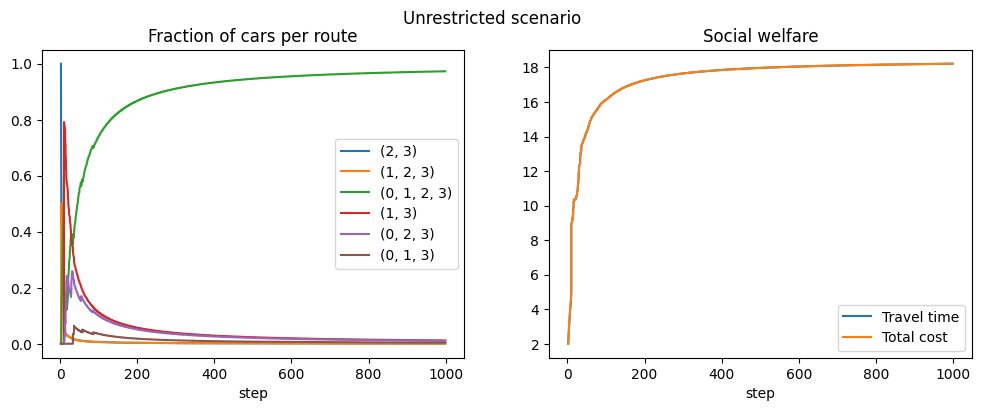

In [104]:
plot_results(car_stats, title='Unrestricted scenario')

### Restricted

In [105]:
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
model.set_edge_restriction((1, 2), False)
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

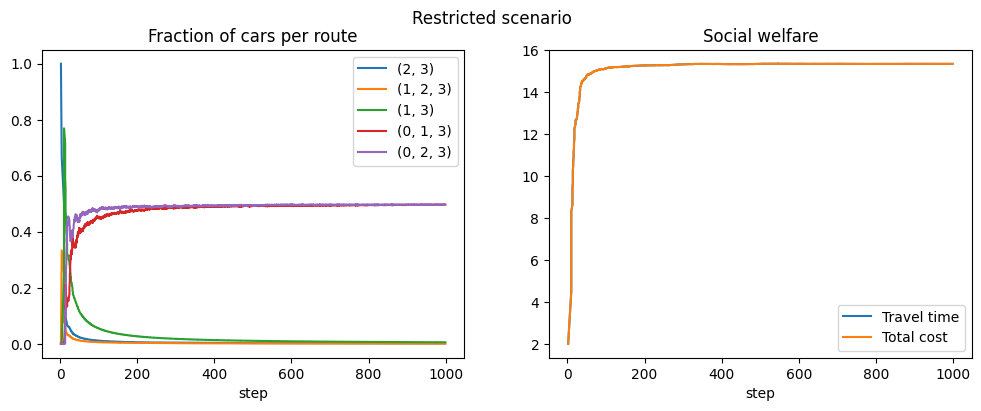

In [106]:
plot_results(car_stats, title='Restricted scenario')

### Tolling

Mean travel time with tolling: -15.463762130910593
Mean total cost with tolling: -19.694953168827674


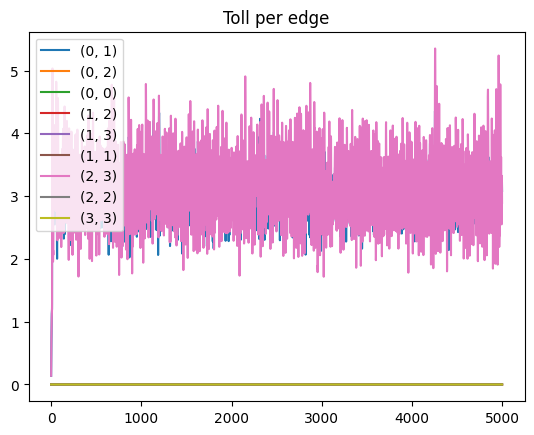

In [107]:
from util.analysis import plot_toll_per_edge, plot_cars_per_edge

network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts), tolls=True, beta=1, R=0.1)
step_stats, car_stats = model.run_sequentially(5000, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats["total_cost"]).mean()}')

plot_toll_per_edge(step_stats)

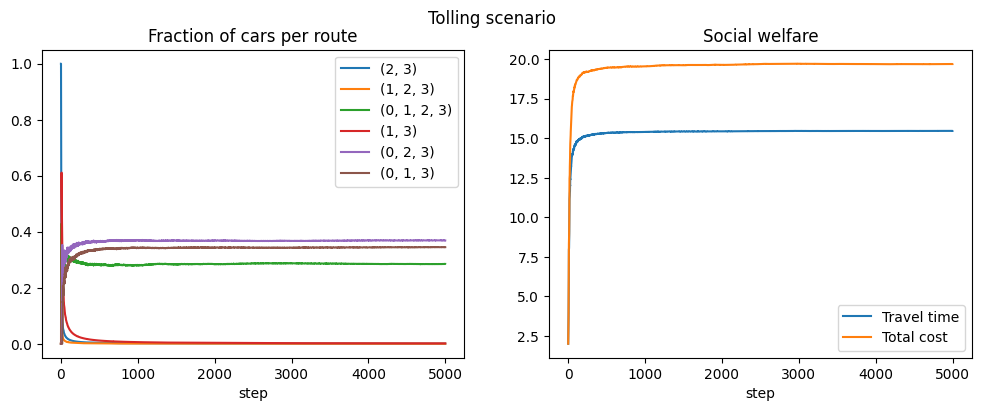

In [108]:
plot_results(car_stats, title='Tolling scenario')

## Compare unrestricted vs. restricted vs. tolling for optimal capacity

In [4]:
capacity = 13

In [109]:
# Unrestricted
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
_, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

# Restricted
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
model.set_edge_restriction((1, 2), False)
_, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

# Tolling
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts), tolls=True, beta=1, R=0.5)
_, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats_tolling["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats_tolling["total_cost"]).mean()}')

Unrestricted mean travel time: -17.996971532404604
Restricted mean travel time: -15.36016511867905
Mean travel time with tolling: -15.422279792746114
Mean total cost with tolling: -19.562522728732258


Text(0.5, 0.98, "Braess' Paradox")

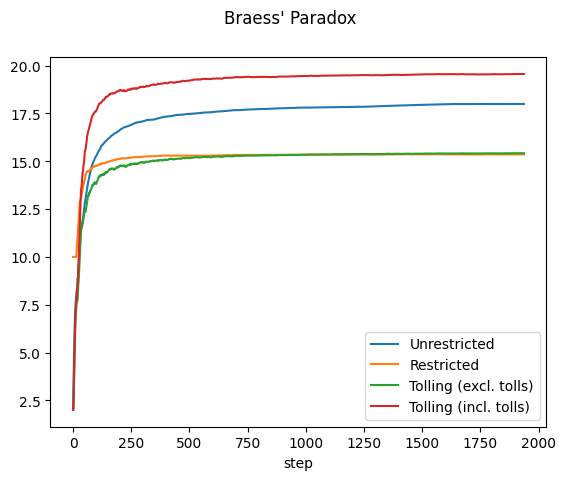

In [112]:
fig, ax = plt.subplots(1, 1)

pd.DataFrame({
    'Unrestricted': car_stats_unrestricted['travel_time'], 
    'Restricted': car_stats_restricted['travel_time'], 
    'Tolling (excl. tolls)': car_stats_tolling['travel_time'], 
    'Tolling (incl. tolls)': car_stats_tolling['total_cost']}).expanding().mean().plot(ax=ax, xlabel='step')

fig.suptitle("Braess' Paradox")

## Use different values for `value_of_money` and check for fairness

# Playground

In [22]:
df = pd.DataFrame({'X': [1, 2, 2, 1, 3]})

<Axes: >

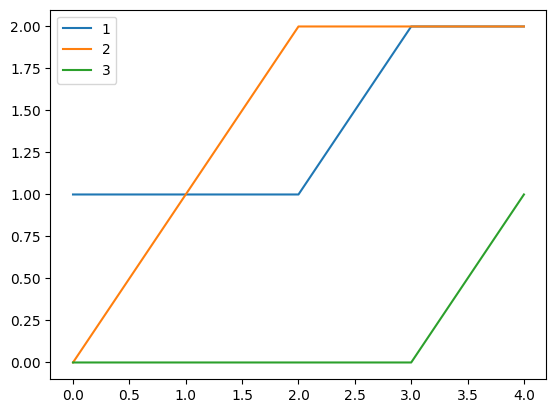

In [27]:
pd.DataFrame({x: df['X'] == x for x in df['X'].unique()}).cumsum().plot()